In [6]:
import torch
import shap
import numpy as np

c:\Users\adolf\Desktop\ENVIROMENT\PF_NLP_DEEP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LOAD MODEL 

In [13]:
# import necessary dependencies
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from gensim.models.keyedvectors import load_word2vec_format

import pandas as pd

import re

from typing import List, Tuple, Any


def tokenize_tweet(tweet: str) -> List[str]:
    """
      Tokenizes a given tweet by splitting the text into words, and doing any cleaning, replacing or normalization deemed useful

      Args:
          tweet (str): The tweet text to be tokenized.

      Returns:
          list[str]: A list of strings, representing the tokenized components of the tweet.
    """
    # TODO: Complete the tokenize_tweet function
    # replace the usernas with a specific token
    global USR_MENTION_TOKEN
    global URL_TOKEN
    USR_MENTION_TOKEN = "<!USR_MENTION>"
    URL_TOKEN = "<!URL>"
    tweet = re.sub(r'@\w+', USR_MENTION_TOKEN, tweet)

    # replace the urls with a specific token
    tweet = re.sub(r'http\S+', URL_TOKEN, tweet)

    # remove the hashtags from the tweet
    tweet = re.sub(r'#\w+', '', tweet)

    return tweet.split()


def generate_text_target_pairs(file_path: str) -> Tuple[List[List[str]], List[int]]:
    """
    Load data from a specified file path, extract texts and targets, and tokenize the texts using the tokenize_tweet function.

    Parameters:
    file_path (str): The path to the dataset file.

    Returns:
    Tuple[List[str], List[int]]: Lists of texts and corresponding targets.
    """
    try:
        # TODO: Read the corresponding csv
        data: pd.DataFrame = pd.read_csv(file_path)

        # TODO: Obtain the text column from data
        texts: List[str] = data['text'].tolist()

        # TODO: Obtain targets, 0 for human and 1 for bot
        # replace the target column with a binary representation
        data['tag'] = data['account.type'].replace('human', 0)
        data['tag'] = data['tag'].replace('bot', 1)
        targets: List[int] = data['tag'].tolist()

        # TODO: Return tokenized texts, and targets
        return [tokenize_tweet(text) for text in texts], targets

    except FileNotFoundError:
        print(f"{file_path} not found. Please check the file path.")


class TweepFakeDataset(Dataset):
    """
    A PyTorch Dataset for the TweepFake dataset.

    Attributes:
        texts (List[List[str]]): List of tweets tokens.
        targets (List[str]): List of target labels.
    """

    def __init__(self,
                 texts: List[List[str]],
                 targets: List[int]
                 ):
        """
        Initializes the TweepFakeDataset with the given file path.

        Args:
            texts (List[List[str]]): List of tweets tokens.
            targets (List[str]): List of target labels.
        """
        # TODO: Complete the init function
        # initialise the super class
        super().__init__()
        self.texts = texts
        self.targets = targets
        self._len = len(self.texts)

    def __len__(self) -> int:
        """Returns the length of the dataset."""
        # TODO: Complete the len function
        return self._len  # VALID IF WE DONT UPDATE THE DATASET, OTHERWISE WOULD NEED TO IMPLEMENT AN _update_len METHOD

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the embedded tensor and target for the text at the specified index.

        Args:
            idx (int): Index of the item.

        Returns:
            Tuple[List[str], List[int]]: A tuple containing the BoW vector and the target label.
        """
        # TODO: Complete the getitem function

        return self.texts[idx], self.targets[idx]


def load_data(
    save_path: str = "C:/Users/adolf/Desktop/NLPDEEP/NLP_Data/data",
    batch_size: int = 64
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Load the TweepFake dataset from the specified path, and split it into training, validation, and test sets.

    Args:
        save_path (str): The path to save the dataset.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: DataLoaders for the training, validation, and test sets.
    """

    # get the initial data
    train_texts, train_targets = generate_text_target_pairs(
        save_path + "/train.csv")
    val_texts, val_targets = generate_text_target_pairs(
        save_path + "/validation.csv")
    ts_texts, ts_targets = generate_text_target_pairs(save_path + "/test.csv")

    # create the datasets
    train_dataset = TweepFakeDataset(train_texts, train_targets)
    val_dataset = TweepFakeDataset(val_texts, val_targets)
    test_dataset = TweepFakeDataset(ts_texts, ts_targets)

    #! CREATE THE GLOBAL W2V MODEL
    global w2v_model  # ! THIS IS NOT THE BEST PRACTICE, BUT IT IS USED HERE FOR SIMPLICITY
    w2v_model = load_word2vec_format(
        "C:/Users/adolf/Desktop/NLPDEEP/NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)

    # create the dataloaders
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_dataloader = DataLoader(
        test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    return train_dataloader, val_dataloader, test_dataloader


def collate_fn(batch: List[Tuple[List[str], int]],
               ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Prepares and returns a batch for training/testing in a torch model.

    This function sorts the batch by the length of the text sequences in descending order,
    tokenizes the text using a pre-defined word-to-index mapping, pads the sequences to have
    uniform length, and converts labels to tensor.

    Args:
        batch (List[Tuple[List[str], int]]): A list of tuples, where each tuple contains a
                                             list of words (representing a text) and an integer label.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing three elements:
            - texts_padded (torch.Tensor): A tensor of padded word indices of the text.
            - labels (torch.Tensor): A tensor of labels.
            - lengths (torch.Tensor): A tensor representing the lengths of each text sequence.
    """
    # get the w2v model from the global scope
    global w2v_model

    # TODO: Sort the batch by the length of text sequences in descending order
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)

    # TODO: Unzip texts and labels from the sorted batch
    texts: List[str]
    labels: List[int]
    texts, labels = zip(*batch)

    # convert the elements of the labels list to int
    labels = list(labels)
    labels = [int(label) for label in labels]

    # TODO: Convert texts to indices using the word2idx function and w2v_model
    texts_indx: List[torch.Tensor] = [
        word2idx(w2v_model, tweet) for tweet in texts]

    # TODO: Calculate the lengths of each element of texts_indx.
    # The minimum length shall be 1, in order to avoid later problems when training the RNN
    lengths: List[torch.Tensor] = [max(len(tweet), 1) for tweet in texts_indx]

    # TODO: Pad the text sequences to have uniform length
    texts_padded: torch.Tensor = pad_sequence(texts_indx, batch_first=True)

    # TODO: Convert labels to tensor
    labels: torch.Tensor = torch.tensor(labels)

    return texts_padded, labels, lengths


def word2idx(embedding_model: Any, tweet: List[str]) -> torch.Tensor:
    """
    Converts a tweet to a list of word indices based on an embedding model.

    This function iterates through each word in the tweet and retrieves its corresponding index
    from the embedding model's vocabulary. If a word is not present in the model's vocabulary,
    it is skipped.

    Args:
        embedding_model (Any): The embedding model with a 'key_to_index' attribute, which maps words to their indices.
        tweet (List[str]): A list of words representing the tweet.

    Returns:
        torch.Tensor: A tensor of word indices corresponding to the words in the tweet.
    """
    # TODO: Complete the function according to the requirements

    # get the indices of the words in the tweet
    indices = [embedding_model.key_to_index[word]
               for word in tweet if word in embedding_model.key_to_index]

    return torch.tensor(indices)


In [14]:
'''import sys
sys.path.append('../RNNModelTrain')  # Agrega la ruta de la carpeta que contiene archivo1.py

from data import load_data'''

# Load the dat

In [18]:
# Cargar tus datos
train_loader, val_loader, test_loader = load_data()

In [21]:
# Obtener un lote de datos de entrenamiento
batch_texts, batch_labels, batch_lengths = next(iter(train_loader))


# Crear datos de entrada en el formato adecuado para SHAP
datos_de_entrada = (batch_texts, batch_lengths)

In [23]:
# Cargar el modelo
from torch.jit import RecursiveScriptModule

model_path = "./model.pt"
model: RecursiveScriptModule = torch.jit.load(f'{model_path}')

# Crear un objeto explainer de SHAP
explainer = shap.Explainer(model)

# Explicar las predicciones del modelo
shap_values = explainer(data=datos_de_entrada)

# Visualizar los valores SHAP
shap.plots.waterfall(shap_values[0])


ValueError: masker cannot be None.

In [37]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# California Housing Prices
dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [38]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

ExactExplainer explainer: 4129it [22:12,  3.10it/s]                          


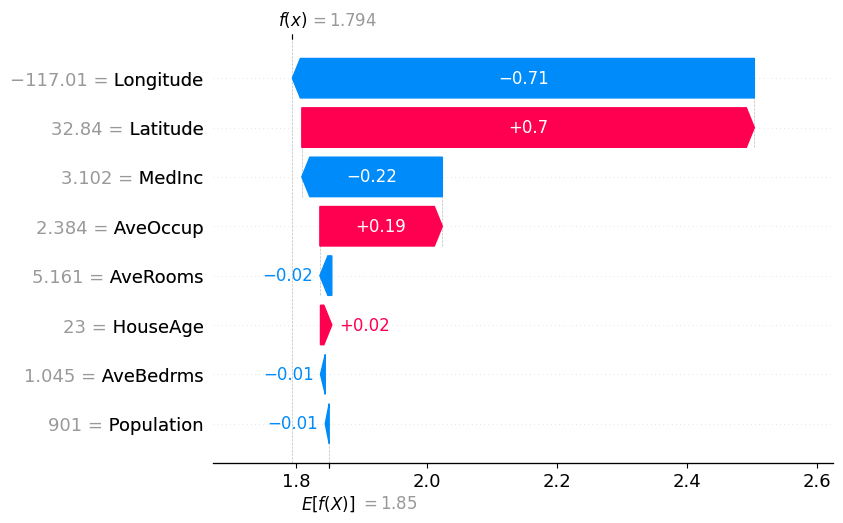

In [39]:
# Visualizes the SHAP values
shap.plots.waterfall(shap_values[0])

In [45]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last output
        return out.squeeze(1)  # Squeeze to remove the singleton dimension


# Load the California Housing dataset
dataset = fetch_california_housing(as_frame=True)
X = dataset['data']
y = dataset['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Initialize the RNN model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
rnn_model = RNNModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)

# Train the RNN model
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.unsqueeze(1))
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Compute SHAP values (not implemented here)
# shap_values = compute_shap_values(rnn_model, X_test_scaled)




Epoch [10/100], Loss: 2.8464
Epoch [20/100], Loss: 0.6546
Epoch [30/100], Loss: 0.6359
Epoch [40/100], Loss: 0.5496
Epoch [50/100], Loss: 0.4635
Epoch [60/100], Loss: 0.4486
Epoch [70/100], Loss: 0.4315
Epoch [80/100], Loss: 0.4183
Epoch [90/100], Loss: 0.4091
Epoch [100/100], Loss: 0.4016


In [46]:
import shap
import numpy as np

# Define a function that acts as a model evaluator for shap
def model_evaluator(X):
    # Convert X to a PyTorch tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    # Pass X through the trained RNN model
    outputs = rnn_model(X_tensor)
    
    # Return the predictions as a numpy array
    return outputs.detach().numpy()

# Initialize the SHAP explainer
explainer = shap.Explainer(model_evaluator, X_train_scaled)

# Compute SHAP values for the testing set
shap_values = explainer(X_test_scaled)

# Print SHAP values for the first instance in the testing set
print("SHAP values for the first instance in the testing set:")
print(shap_values.values[0])



IndexError: too many indices for tensor of dimension 2